In [1]:
import os
import string
import json
from collections import Counter
from torchtext.data.utils import get_tokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


c:\Users\vinde\Documents\Projects\INF265_3\.venv\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


# TASK 2.1 WORD EMBEDDING

In [2]:
def read_and_tokenize(file_path):
    tokenizer = get_tokenizer('basic_english')
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    text = preprocess_text(text)
    return tokenizer(text)

def preprocess_text(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return text

def tokenize_directory(directory_path):
    tokenized_texts = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.txt'): 
            file_path = os.path.join(directory_path, file_name)
            tokens = read_and_tokenize(file_path)
            tokenized_texts.extend(tokens)
    return tokenized_texts

In [3]:
train_folder = 'inf265_v24_project03_data/data_train'
val_folder = 'inf265_v24_project03_data/data_val'
test_folder = 'inf265_v24_project03_data/data_test'

tokenized_train = tokenize_directory(train_folder)
tokenized_val = tokenize_directory(val_folder)
tokenized_test = tokenize_directory(test_folder)

print(f"Number of words in training data: {len(tokenized_train)}")
print(f"Number of words in validation data: {len(tokenized_val)}")
print(f"Number of words in test data: {len(tokenized_test)}")

Number of words in training data: 2348007
Number of words in validation data: 43758
Number of words in test data: 107587


In [4]:
def build_vocabulary(tokenized_texts, min_freq=100):
    word_freq = Counter(tokenized_texts)
    vocab = {'<unk>': 0}  
    index = 1  
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocab[word] = index
            index += 1
    total_words = sum(word_freq.values())
    distinct_words = len(word_freq)
    vocab_size = len(vocab)
    return vocab, total_words, distinct_words, vocab_size

vocab, total_words, distinct_words, vocab_size = build_vocabulary(tokenized_train, min_freq=100)


In [5]:
print(f"Total number of words in the training dataset: {total_words}")
print(f"Number of distinct words in the training dataset: {distinct_words}")
print(f"Size of the defined vocabulary (words appearing at least 100 times): {vocab_size}")

print("\nComments on Results:")
if vocab_size < distinct_words:
    print("The defined vocabulary is smaller than the total number of distinct words,")
    print("indicating that not all words appear frequently enough to be included.")
else:
    print("All distinct words appear frequently and are included in the vocabulary.")

Total number of words in the training dataset: 2348007
Number of distinct words in the training dataset: 52585
Size of the defined vocabulary (words appearing at least 100 times): 2082

Comments on Results:
The defined vocabulary is smaller than the total number of distinct words,
indicating that not all words appear frequently enough to be included.


In [6]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)  
        self.linear = nn.Linear(embedding_dim, vocab_size)  

    def forward(self, inputs):
        embeds = self.embeddings(inputs)  
        embeds_mean = torch.mean(embeds, dim=1)  
        out = self.linear(embeds_mean)  
        log_probs = F.log_softmax(out, dim=1) 
        return log_probs

In [7]:
class CBOWDataset(Dataset):
    def __init__(self, tokenized_texts, word_to_ix, context_size):
        self.word_to_ix = word_to_ix  
        self.data = []
        for i in range(context_size, len(tokenized_texts) - context_size):
            context = [tokenized_texts[j] for j in range(i - context_size, i + context_size + 1) if j != i]
            target = tokenized_texts[i]
            context_indices = [word_to_ix.get(word, word_to_ix['<unk>']) for word in context]
            target_index = word_to_ix.get(target, word_to_ix['<unk>'])
            self.data.append((context_indices, target_index))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context_indices, target_index = self.data[idx]
        return torch.tensor(context_indices, dtype=torch.long), torch.tensor(target_index, dtype=torch.long)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
word_to_ix = {word: i for i, word in enumerate(vocab)}
train_data = CBOWDataset(tokenized_train, word_to_ix, context_size=4)
val_data = CBOWDataset(tokenized_val, word_to_ix, context_size=4)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

model_losses = {}

In [9]:
def compute_class_weights(word_to_ix, dataset):
    all_targets = np.array([target for _, target in dataset])
    
    class_indices = np.array(list(word_to_ix.values())) 
    
    class_weights = compute_class_weight('balanced', classes=class_indices, y=all_targets)
    
    print("Class weights calculated successfully:", class_weights)
    return torch.tensor(class_weights, dtype=torch.float).to(device)

class_weights = compute_class_weights(word_to_ix, train_data)

Class weights calculated successfully: [3.01303597e-03 3.03161636e+00 4.90757740e-02 ... 1.11659533e+01
 1.00692972e+01 1.07405837e+01]


In [10]:
def train_cbow_models(vocab_size, embedding_dims, epochs, learning_rate):
    for embedding_dim in embedding_dims:
        model = CBOWModel(vocab_size, embedding_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for context, target in train_loader:
                context, target = context.to(device), target.to(device)
                optimizer.zero_grad()
                log_probs = model(context)
                loss = criterion(log_probs, target)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            average_train_loss = total_loss / len(train_loader)
            print(f'Epoch {epoch}, Average Training Loss: {average_train_loss}')

        model_path = f'cbow_model_{embedding_dim}.pth'
        torch.save(model.state_dict(), model_path)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for context, target in val_loader:
                context, target = context.to(device), target.to(device)
                log_probs = model(context)
                loss = criterion(log_probs, target)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        model_losses[embedding_dim] = avg_val_loss
        print(f'Model with embedding dim {embedding_dim}, Validation Loss: {avg_val_loss}')

    best_embedding_dim = min(model_losses, key=model_losses.get)
    print(f'The best model has an embedding dimension of {best_embedding_dim} with a validation loss of {model_losses[best_embedding_dim]}')

    return best_embedding_dim




In [11]:
vocab_size = len(vocab)
context_size = 4
embedding_dims = [10, 12, 16]  
epochs = 5
learning_rate = 0.01

In [12]:
with open('tokenized_text.json', 'w') as f:
    json.dump(tokenized_train, f)

with open('vocabulary.json', 'w') as f:
    json.dump(vocab, f)

In [13]:
model = CBOWModel(vocab_size, 16)
model.load_state_dict(torch.load('cbow_model_16.pth', map_location=device))
model.to(device)

CBOWModel(
  (embeddings): Embedding(2082, 16)
  (linear): Linear(in_features=16, out_features=2082, bias=True)
)

In [14]:
embeddings = model.embeddings.weight.data

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

norm_embeddings = embeddings / embeddings.norm(p=2, dim=1, keepdim=True)

cosine_sim_matrix = cosine_similarity(norm_embeddings.cpu().numpy())

In [16]:
def find_most_similar_words(word, word_to_ix, ix_to_word, similarity_matrix, top_n=10):
    word_index = word_to_ix[word]
    word_similarities = similarity_matrix[word_index]
    
    most_similar_indices = word_similarities.argsort()[-top_n-1:-1][::-1]
    
    similar_words = [ix_to_word[ix] for ix in most_similar_indices]
    return similar_words

ix_to_word = {index: word for word, index in word_to_ix.items()}

chosen_words = ["me", "white", "man", "have", "be", "child", "yes", "what"]

for word in chosen_words:
    similar_words = find_most_similar_words(word, word_to_ix, ix_to_word, cosine_sim_matrix)
    print(f"Words similar to '{word}': {similar_words}")


Words similar to 'me': ['thee', 'us', 'him', 'arthur', 'her', 'ourselves', 'professor', 'them', 'god', 'mine']
Words similar to 'white': ['blue', 'delicate', 'yellow', 'small', 'thin', 'gray', 'large', 'handsome', 'black', 'bright']
Words similar to 'man': ['woman', 'soldier', 'lady', 'wife', 'gentleman', 'children', 'comrades', 'girl', 'chiefs', 'child']
Words similar to 'have': ['had', 've', 'be', 'has', 'having', 'speech', 'also', 'ill', 'hast', 'life']
Words similar to 'be': ['being', 'fully', 'have', 'remain', 'been', 'are', 'look', 'material', 'am', 'finally']
Words similar to 'child': ['lips', 'bodies', 'hands', 'fire', 'seat', 'knees', 'wolf', 'cook', 'woman', 'boy']
Words similar to 'yes': ['honor', 'sir', 'martin', 'ah', 'certainly', 'mon', 'god', 'candide', 'eh', 'devil']
Words similar to 'what': ['neither', 'impossible', 'that', 'certainly', 'russia', 'otherwise', 'really', 'whether', 'never', 'reader']


In [17]:
import csv

def save_vocab(vocab, file_path):
    with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(['Word', 'Index'])
        for word, index in vocab.items():
            writer.writerow([word, index])

def save_embeddings(model, vocab, file_path):
    with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(['Word', 'Embedding'])
        for word, index in vocab.items():
            index_tensor = torch.tensor([index], device=device)
            embedding = model.embeddings(index_tensor).detach().cpu().numpy()  
            embedding = embedding.flatten()
            writer.writerow([word, '\t'.join(map(str, embedding))])

save_vocab(vocab, 'vocab_indices.tsv')
save_embeddings(model, vocab, 'vocab_embeddings.tsv')


# TASK 2.2 CONJUGATING BE AND HAVE

In [18]:
import pandas as pd
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def parse_embedding(embedding_str):
    clean_str = embedding_str.strip('[]"')
    return [float(num) for num in clean_str.split()]

def load_embeddings(embeddings_file, indices_file):
    indices = pd.read_csv(indices_file, sep='\t')
    word_to_ix = {row['Word']: int(row['Index']) for index, row in indices.iterrows()}
    embeddings_df = pd.read_csv(embeddings_file, sep='\t', converters={1: parse_embedding})
    embedding_list = embeddings_df['Embedding'].apply(lambda x: torch.tensor(x, dtype=torch.float))
    embeddings_tensor = torch.stack(embedding_list.tolist())

    return embeddings_tensor, word_to_ix

embeddings, word_to_ix = load_embeddings('vocab_embeddings.tsv', 'vocab_indices.tsv')
vocab_size = len(word_to_ix)


In [19]:
from torchtext.data.utils import get_tokenizer

def tokenize_directory(directory_path, target_verbs, word_to_ix, tokenizer):
    context_data = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(directory_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read().lower().translate(str.maketrans('', '', string.punctuation))
                sentences = text.split('\n')
                for sentence in sentences:
                    words = tokenizer(sentence)
                    for i, word in enumerate(words):
                        if word in target_verbs:
                            start = max(0, i - 2)
                            end = min(len(words), i + 3)
                            context = [word_to_ix.get(w, word_to_ix['<unk>']) for w in words[start:i] + words[i+1:end]]
                            target = verb_to_index[word]  
                            context_data.append((context, target))
    return context_data

tokenizer = get_tokenizer('basic_english')
target_verbs = ['am', 'is', 'are', 'was', 'were', 'being', 'been', 'have', 'has', 'had', 'having']
verb_to_index = {
    'am': 0, 'is': 1, 'are': 2, 'was': 3, 'were': 4, 'being': 5, 'been': 6,
    'have': 7, 'has': 8, 'had': 9, 'having': 10
}


tokenized_train = tokenize_directory(train_folder, target_verbs, word_to_ix, tokenizer)
tokenized_val = tokenize_directory(val_folder, target_verbs, word_to_ix, tokenizer)
tokenized_test = tokenize_directory(test_folder, target_verbs, word_to_ix, tokenizer)



In [20]:
class Dataset(Dataset):
    def __init__(self, data):
        self.contexts = [torch.tensor(context, dtype=torch.long) for context, _ in data]
        self.targets = torch.tensor([target for _, target in data], dtype=torch.long)

    def __len__(self):
        return len(self.contexts)

    def __getitem__(self, idx):
        return self.contexts[idx], self.targets[idx]


In [21]:
def collate_fn(batch):
    contexts, targets = zip(*batch)
    contexts = [torch.tensor(context) for context in contexts]
    targets = torch.tensor(targets)
    
    contexts_padded = pad_sequence(contexts, batch_first=True, padding_value=0)
    
    return contexts_padded, targets


train_dataset = Dataset(tokenized_train)
test_dataset = Dataset(tokenized_test)
val_dataset = Dataset(tokenized_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [22]:
be_forms = ['am', 'is', 'are', 'was', 'were', 'being', 'been']
have_forms = ['have', 'has', 'had', 'having']

num_classes = len(be_forms) + len(have_forms)
print("Number of classes (unique conjugations):", num_classes)


Number of classes (unique conjugations): 11


In [23]:
def positional_encoding(max_len, emb_dim):
    # Create a matrix of shape (max_len, emb_dim) for positional encodings
    pe = torch.zeros(max_len, emb_dim)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * (-math.log(10000.0) / emb_dim))
    
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    pe = pe.unsqueeze(0)  # Add batch dimension [1, max_len, emb_dim] for broadcasting
    return pe

In [24]:
class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, max_len):
        super(SimpleMLP, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.positional_encodings = positional_encoding(max_len, embedding_dim).to(device)
        self.fc1 = nn.Linear(embedding_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, inputs):
        embedded = self.embeddings(inputs) 
        seq_len = inputs.size(1)
        embedded += self.positional_encodings[:, :seq_len, :]  
        embedded = embedded.mean(dim=1)  
        x = F.relu(self.fc1(embedded))
        x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        return output


In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.emb_dim = emb_dim
        
        assert emb_dim % n_heads == 0
        self.depth = emb_dim // n_heads
        
        self.Wq = nn.ModuleList([nn.Linear(emb_dim, self.depth) for _ in range(n_heads)])
        self.Wk = nn.ModuleList([nn.Linear(emb_dim, self.depth) for _ in range(n_heads)])
        self.Wv = nn.ModuleList([nn.Linear(emb_dim, self.depth) for _ in range(n_heads)])
        
        self.final_linear = nn.Linear(emb_dim, emb_dim)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        Q = torch.cat([self.Wq[i](x).view(batch_size, -1, self.depth) for i in range(self.n_heads)], dim=2)
        K = torch.cat([self.Wk[i](x).view(batch_size, -1, self.depth) for i in range(self.n_heads)], dim=2)
        V = torch.cat([self.Wv[i](x).view(batch_size, -1, self.depth) for i in range(self.n_heads)], dim=2)
        
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.depth ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        attended = torch.matmul(attention_weights, V)
        
        attended = attended.view(batch_size, -1, self.n_heads * self.depth)
        output = self.final_linear(attended)
        
        return output

class AttentionMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, max_len, n_heads):
        super(AttentionMLP, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.positional_encodings = positional_encoding(max_len, embedding_dim).to(device)
        self.attention = MultiHeadAttention(embedding_dim, n_heads)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, inputs):
        embedded = self.embeddings(inputs)  
        seq_len = inputs.size(1)
        pos_encodings = self.positional_encodings[:, :seq_len, :] 
        embedded += pos_encodings
        embedded = self.layer_norm(embedded)
        attended = self.attention(embedded)
        attended = attended.mean(dim=1)
        x = F.relu(self.fc1(attended))
        output = self.fc2(x)
        return output




In [26]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, max_len):
        super(SimpleRNN, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.positional_encodings = positional_encoding(max_len, embedding_dim).to(device)
        self.lstm = nn.LSTM(embedding_dim, 128, batch_first=True, dropout=0.5, num_layers=2)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, inputs):
        embedded = self.embeddings(inputs) 
        seq_len = inputs.size(1)
        embedded += self.positional_encodings[:, :seq_len, :] 
        lstm_out, (h_n, c_n) = self.lstm(embedded)
        final_output = lstm_out[:, -1, :]  
        output = self.fc(final_output)
        return output


In [27]:
def train_model(model, train_loader, val_loader, num_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    device = next(model.parameters()).device  

    for epoch in range(num_epochs):
        model.train()  
        total_loss = 0
        for contexts, targets in train_loader:
            contexts, targets = contexts.to(device), targets.to(device)
            optimizer.zero_grad()  
            outputs = model(contexts)
            loss = criterion(outputs, targets)
            loss.backward()  
            optimizer.step()  
            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss/len(train_loader)}')

        model.eval()  
        with torch.no_grad():
            validation_loss = 0
            for val_contexts, val_targets in val_loader:
                val_contexts, val_targets = val_contexts.to(device), val_targets.to(device)
                val_outputs = model(val_contexts)
                val_loss = criterion(val_outputs, val_targets)
                validation_loss += val_loss.item()
            print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {validation_loss/len(val_loader)}')

    return model 

embedding_dim = embeddings.size(1)


In [28]:
max_len=50

simple_mlp = SimpleMLP(vocab_size, embedding_dim, num_classes, max_len)
attention_mlp = AttentionMLP(vocab_size, embedding_dim, num_classes, max_len, n_heads=8)
simple_rnn = SimpleRNN(vocab_size, embedding_dim, num_classes, max_len)


In [29]:
attention_mlp.embeddings.weight = nn.Parameter(embeddings)
attention_mlp.to(device)
train_model(attention_mlp, train_loader, val_loader)

Epoch 1/5, Training Loss: 1.3899660318797205
Epoch 1/5, Validation Loss: 1.3802517177285374
Epoch 2/5, Training Loss: 1.2678373507479586
Epoch 2/5, Validation Loss: 1.3699144133039423
Epoch 3/5, Training Loss: 1.2363972117761737
Epoch 3/5, Validation Loss: 1.3014521735745508
Epoch 4/5, Training Loss: 1.2214995037607208
Epoch 4/5, Validation Loss: 1.2989961247186403
Epoch 5/5, Training Loss: 1.2064502916192816
Epoch 5/5, Validation Loss: 1.3072451103377987


AttentionMLP(
  (embeddings): Embedding(2082, 16)
  (attention): MultiHeadAttention(
    (Wq): ModuleList(
      (0-7): 8 x Linear(in_features=16, out_features=2, bias=True)
    )
    (Wk): ModuleList(
      (0-7): 8 x Linear(in_features=16, out_features=2, bias=True)
    )
    (Wv): ModuleList(
      (0-7): 8 x Linear(in_features=16, out_features=2, bias=True)
    )
    (final_linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
)

In [30]:
simple_mlp.embeddings.weight = nn.Parameter(embeddings)
simple_mlp.to(device)
train_model(simple_mlp, train_loader, val_loader)

Epoch 1/5, Training Loss: 1.4880880003613175
Epoch 1/5, Validation Loss: 1.3951689762038153
Epoch 2/5, Training Loss: 1.3711579987453215
Epoch 2/5, Validation Loss: 1.409889168835975
Epoch 3/5, Training Loss: 1.3490811349648675
Epoch 3/5, Validation Loss: 1.4624693385652594
Epoch 4/5, Training Loss: 1.3356421805406016
Epoch 4/5, Validation Loss: 1.9456583430638184
Epoch 5/5, Training Loss: 1.3296295510145504
Epoch 5/5, Validation Loss: 1.4816955150784672


SimpleMLP(
  (embeddings): Embedding(2082, 16)
  (fc1): Linear(in_features=16, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=11, bias=True)
)

In [31]:
simple_rnn.embeddings.weight = nn.Parameter(embeddings)
simple_rnn.to(device)
train_model(simple_rnn, train_loader, val_loader)


Epoch 1/5, Training Loss: 1.3383053760009305
Epoch 1/5, Validation Loss: 1.2730673285754952
Epoch 2/5, Training Loss: 1.2428110385306097
Epoch 2/5, Validation Loss: 1.2382161174271558
Epoch 3/5, Training Loss: 1.2213530923196307
Epoch 3/5, Validation Loss: 1.2462821925008618
Epoch 4/5, Training Loss: 1.2121169749606489
Epoch 4/5, Validation Loss: 1.2668418988988206
Epoch 5/5, Training Loss: 1.2154065965228795
Epoch 5/5, Validation Loss: 1.2539471734214473


SimpleRNN(
  (embeddings): Embedding(2082, 16)
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=11, bias=True)
)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, data_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    return all_targets, all_predictions, accuracy



In [33]:
sm_target, sm_preds, sm_accuracy = evaluate_model(simple_mlp, val_loader)
print(f'Simple MLP Accuracy: {sm_accuracy}')

am_target, am_preds, am_accuracy = evaluate_model(attention_mlp, val_loader)
print(f'Attention MLP Accuracy: {am_accuracy}')

sr_target, sr_preds, sr_accuracy = evaluate_model(simple_rnn, val_loader)
print(f'Simple RNN Accuracy: {sr_accuracy}')

Simple MLP Accuracy: 0.4980777445536096
Attention MLP Accuracy: 0.5143101238786844
Simple RNN Accuracy: 0.5215719777872704


In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(true_labels, predictions, classes, title="Confusion matrix"):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()


index_to_verb = {index: verb for verb, index in verb_to_index.items()}
classes = [index_to_verb[i] for i in sorted(index_to_verb)]

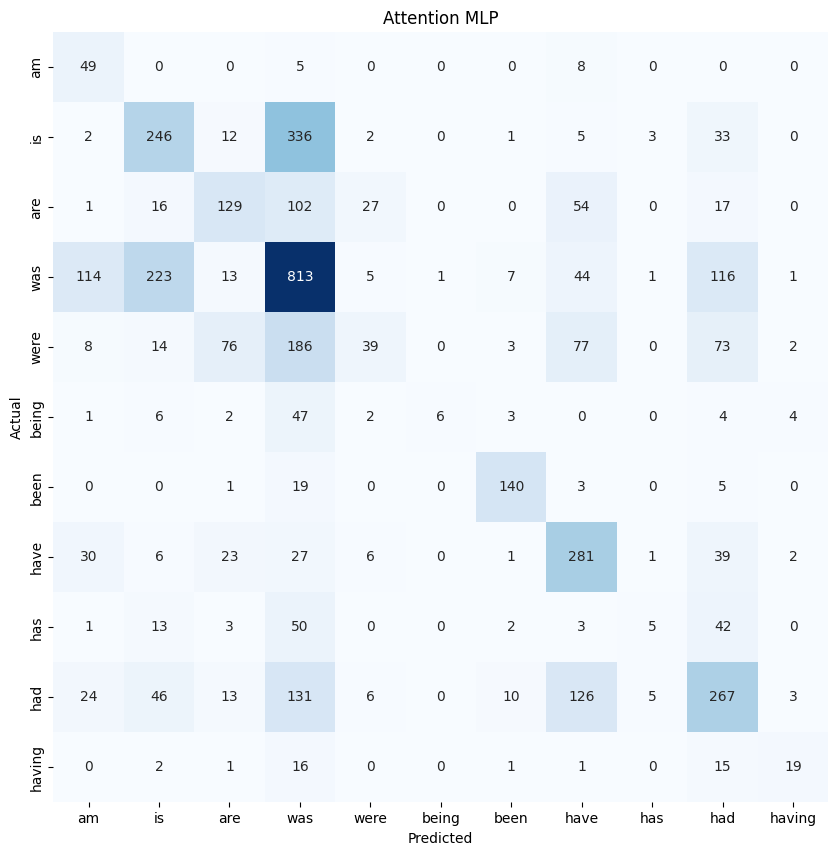

In [35]:
test_target, test_preds, _ = evaluate_model(attention_mlp, test_loader)
plot_confusion_matrix(test_target, test_preds, classes, "Attention MLP")


All models are being trained on a CUDA supported RTX 3050. The Simple MLP shows moderate performance with the shortest training time of 38,6 seconds among the three models. MLPs are generally faster to train due to the straightforward architecture. However, the performance is somewhat limited as it has the lowest accuracy of 0,498. The Attention MLP has an improvement in accuracy over the Simple MLP with 0.514, whcih suggests the attention mechanism helps capture the relationships in the data better. This does come at a cost of being a lot more computational complex which resulted in a training time of 114,7 seconds. The performance of Simple RNN model were the best of the three models in accuracy as it is 0,521 with a much more moderate training time, compared to Attention MLP, at 40,4 seconds. 

In the confusion matrix we can see a trend on the diagonal which is what we want. At the same time it does seem to confuse is, are and was a substantial amount of times.

# 2.3 TEXT GENERATION

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, rnn_type='lstm', use_positional_encodings=True):
        super(RNNModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.use_positional_encodings = use_positional_encodings
        if self.use_positional_encodings:
            self.positional_encodings = self.create_positional_encodings(max_len=500, emb_dim=embedding_dim).to(device)  
            
        if rnn_type.lower() == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        else:
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.device = device

    def forward(self, inputs):
        embedded = self.embeddings(inputs) 
        if self.use_positional_encodings:
            seq_len = inputs.size(1)
            embedded += self.positional_encodings[:, :seq_len, :]

        output, _ = self.rnn(embedded)
        final_output = output[:, -1, :] 
        logits = self.fc(final_output)
        return logits

    def create_positional_encodings(self, max_len, emb_dim):
        pe = torch.zeros(max_len, emb_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / emb_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)


In [37]:
configurations = [
    {'embedding_dim': 100, 'hidden_dim': 128, 'num_layers': 1, 'rnn_type': 'lstm'},
    {'embedding_dim': 100, 'hidden_dim': 128, 'num_layers': 2, 'rnn_type': 'lstm'},
    {'embedding_dim': 100, 'hidden_dim': 256, 'num_layers': 2, 'rnn_type': 'gru'}
]


In [38]:
class RNNDataset(Dataset):
    def __init__(self, data):
        self.contexts, self.targets = zip(*data)
        self.contects = torch.tensor(self.contexts, dtype=torch.long)
        self.targets = torch.tensor(self.targets, dtype=torch.long)

    def __len__(self):
        return len(self.contexts)
    
    def __getitem__(self, idx):
        return torch.tensor(self.contexts[idx], dtype=torch.long), self.targets[idx]

In [39]:
def read_and_tokenize(file_path):
    tokenizer = get_tokenizer('basic_english')
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    text = preprocess_text(text)
    sentences = text.split('\n')  
    tokenized_sentences = [tokenizer(sentence) for sentence in sentences if sentence.strip()]
    return tokenized_sentences

def preprocess_text(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return text

def tokenize_directory(directory_path):
    tokenized_texts = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.txt'):  
            file_path = os.path.join(directory_path, file_name)
            sentences = read_and_tokenize(file_path)
            tokenized_texts.extend(sentences) 
    return tokenized_texts

train_folder = 'inf265_v24_project03_data/data_train'
val_folder = 'inf265_v24_project03_data/data_val'
test_folder = 'inf265_v24_project03_data/data_test'

tokenized_train = tokenize_directory(train_folder)
tokenized_val = tokenize_directory(val_folder)
tokenized_test = tokenize_directory(test_folder)

In [40]:
def build_vocabulary(tokenized_texts, min_freq):
    flat_list = [word for sentence in tokenized_texts for word in sentence]
    word_freq = Counter(flat_list)
    vocab = {'<unk>': 0}
    index = 1 
    
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocab[word] = index
            index += 1
    
    total_words = sum(word_freq.values())
    distinct_words = len(word_freq)
    vocab_size = len(vocab)
    
    return vocab, total_words, distinct_words, vocab_size

vocab, total_words, distinct_words, vocab_size = build_vocabulary(tokenized_train, min_freq=15)

word_to_ix = {word: i for i, word in enumerate(vocab)}

In [41]:
def create_sequences(tokenized_texts, word_to_ix, window_size):
    data = []
    for sentence in tokenized_texts:
        indexed_sentence = [word_to_ix.get(word, word_to_ix['<unk>']) for word in sentence]
        for i in range(window_size, len(indexed_sentence)):
            context = indexed_sentence[i-window_size:i]
            target = indexed_sentence[i]
            data.append((context, target))
    return data

window_size = 4

train_data = create_sequences(tokenized_train, word_to_ix, window_size)
val_data = create_sequences(tokenized_val, word_to_ix, window_size)
test_data = create_sequences(tokenized_test, word_to_ix, window_size)

train_dataset = RNNDataset(train_data)
val_dataset = RNNDataset(val_data)
test_dataset = RNNDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [42]:
from torch.optim import Adam

def train_model(model, train_loader, val_loader, epochs=5):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for contexts, targets in train_loader:
            contexts, targets = contexts.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(contexts)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        model.eval()
        correct = 0
        total_val_loss = 0
        with torch.no_grad():
            for contexts, targets in val_loader:
                contexts, targets = contexts.to(device), targets.to(device)
                outputs = model(contexts)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == targets).sum().item()

        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{epochs}: Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

def evaluate_performance(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    print(f'Evaluation Accuracy: {accuracy}')
    return accuracy

In [ ]:
results = {}
for config in configurations:
    print(f"Training with configuration: {config}")
    model = RNNModel(vocab_size, config['embedding_dim'], config['hidden_dim'],
                     config['num_layers'], config['rnn_type'])
    train_model(model, train_loader, val_loader)
    accuracy = evaluate_performance(model, val_loader)
    results[str(config)] = accuracy
    model_path = f"rnn_model_2_{config['embedding_dim']}_{config['hidden_dim']}_{config['num_layers']}_{config['rnn_type']}.pth"
    torch.save(model.state_dict(), model_path)

best_config = max(results, key=results.get)
print(f'Best Model Configuration: {best_config} with Accuracy: {results[best_config]}')

In [44]:
def load_model(model_path, vocab_size, config):
    model = RNNModel(vocab_size, config['embedding_dim'], config['hidden_dim'],
                     config['num_layers'], config['rnn_type'], use_positional_encodings=True)
    model.load_state_dict(torch.load(model_path, map_location=model.device))
    model.eval()  
    model.to(model.device)
    return model


In [45]:
model_lstm_1 = load_model('rnn_model_100_128_1_lstm.pth',vocab_size, configurations[0])


In [46]:
model_lstm_2 = load_model('rnn_model_100_128_2_lstm.pth',vocab_size, configurations[1])

In [47]:
model_gru = load_model('rnn_model_100_256_2_gru.pth',vocab_size, configurations[2])

In [48]:
def beam_search(model, initial_tokens, beam_width, n_words, vocab, ix_to_word, device='cuda'):
    model.eval()
    model.to(device)
    sequences = [(initial_tokens, 0)] 

    for _ in range(n_words):
        all_candidates = []
        for seq, score in sequences:
            seq_tensor = torch.tensor([seq], dtype=torch.long).to(device)
            with torch.no_grad():
                output = model(seq_tensor)
                probabilities = F.softmax(output[-1], dim=0)

            probs, indices = torch.topk(probabilities, beam_width)
            for i in range(beam_width):
                candidate = (seq + [indices[i].item()], score - torch.log(probs[i] + 1e-9).item())  
                all_candidates.append(candidate)

        all_candidates.sort(key=lambda x: x[1])
        sequences = all_candidates[:beam_width]

    return [[' '.join(ix_to_word[ix] for ix in seq)] for seq, _ in sequences] 


In [49]:
initial_sentence = "what are"

initial_tokens = [word_to_ix.get(word, word_to_ix['<unk>']) for word in initial_sentence.split()]
beam_width = 5  
n_words = 8


In [50]:
ix_to_word = {v: k for k, v in word_to_ix.items()}

generated_sequences = beam_search(model_gru, initial_tokens, beam_width, n_words, word_to_ix, ix_to_word)

print("The Gru model")
for i, sequence in enumerate(generated_sequences):
    print(f"Generated Sequence {i+1}: {' '.join(sequence)}")


The Gru model
Generated Sequence 1: what are you going to do you want to think
Generated Sequence 2: what are you going to do you think of that
Generated Sequence 3: what are you going to do you want to be
Generated Sequence 4: what are you going to do you think that it
Generated Sequence 5: what are you going to do you want to want


In [51]:
generated_sequences = beam_search(model_lstm_2, initial_tokens, beam_width, n_words, word_to_ix, ix_to_word)

print("The best LSTM model")
for i, sequence in enumerate(generated_sequences):
    print(f"Generated Sequence {i+1}: {' '.join(sequence)}")

The best LSTM model
Generated Sequence 1: what are you to do with me said he i
Generated Sequence 2: what are you to do with me said the man
Generated Sequence 3: what are you to do with me and i am
Generated Sequence 4: what are you to do with me and i will
Generated Sequence 5: what are you to do with me i am not


The gru model seems to be better at generating meaningful sentences, but both of them struggle a lot with unknown tokens which results in a high frequency of unk in sentences. I should have tried training with more epochs and diverse hyperparameters, but training these models took some time so I did not get to explore this any further. I could maybe have tried using the embeddings from 2.1, but this I also did not get time to implement. The RuntimeError: CUDA error: device-side assert triggered posed a substantial challange for me as this happened everytime all cells were run, and to fix it I had to restart kernel and run all cells again. This only occured in the last 2 days before the deadline and I did not manage to solve this, but it resulted in me having to spend a lot more time on running the cells which is why the training process is not printed in some cases. I just stored the models and loaded them.